In [1]:
import numpy as np
import matplotlib.pyplot as plt

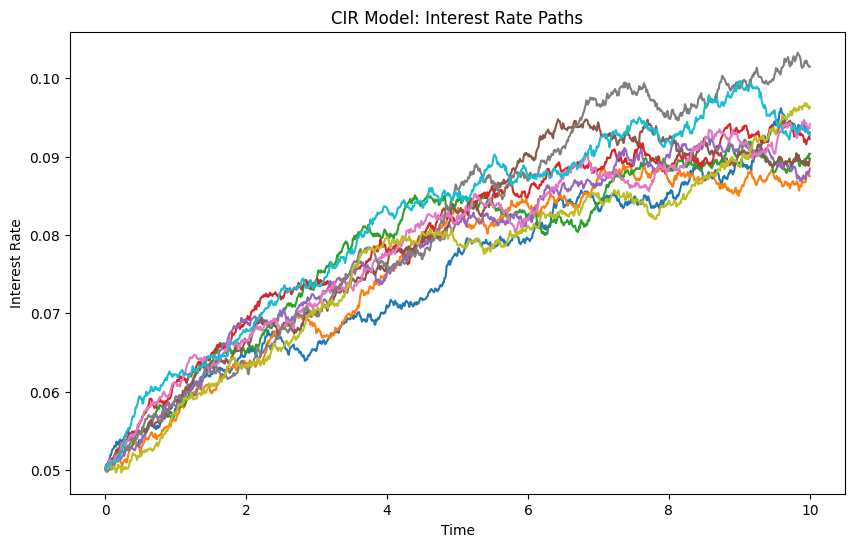

In [2]:
# Parameters
r0 = 0.05  # Initial interest rate
k = 0.2    # Mean reversion speed
theta = 0.1  # Long-term mean interest rate
sigma = 0.01  # Volatility
T = 10  # Time horizon
dt = 0.01  # Time step
n_steps = int(T / dt)
n_simulations = 1000

# Initialize the interest rate path
r = np.zeros((n_steps, n_simulations))
r[0] = r0

# Simulate the interest rate path
np.random.seed(0)
for t in range(1, n_steps):
    dw = np.sqrt(dt) * np.random.normal(size=n_simulations)
    dr = k * (theta - r[t-1]) * dt + sigma * np.sqrt(r[t-1]) * dw
    r[t] = np.abs(r[t-1] + dr)  # Ensure non-negativity

# Plot some sample paths
plt.figure(figsize=(10, 6))
plt.title("CIR Model: Interest Rate Paths")
for i in range(10):
    plt.plot(np.linspace(0, T, n_steps), r[:, i])
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.show()


In [3]:
from scipy.special import gamma
from math import exp, sqrt

def zero_coupon_bond_price_CIR(t, T, r_t, k, theta, sigma):
    h = sqrt(k**2 + 2 * sigma**2)
    A = (2 * h * exp((k + h) * (T - t) / 2)) / (2 * h + (k + h) * (exp(h * (T - t)) - 1))
    A = A**(2 * k * theta / sigma**2)
    B = 2 * (exp(h * (T - t)) - 1) / (2 * h + (k + h) * (exp(h * (T - t)) - 1))
    return A * exp(-B * r_t)

# Calculate and print a sample bond price
t = 0
T = 5
r_t = 0.05
bond_price = zero_coupon_bond_price_CIR(t, T, r_t, k, theta, sigma)
print(f"Zero-coupon bond price at time {t} with maturity {T}: {bond_price}")


Zero-coupon bond price at time 0 with maturity 5: 0.710415616164136


In [5]:
from scipy.stats import ncx2

def european_call_option_on_zcb_CIR(t, T, S, X, r_t, k, theta, sigma):
    h = sqrt(k**2 + 2 * sigma**2)
    rho = 2 * h / (sigma**2 * (exp(h * (T - t)) - 1))
    psi = (k + h) / sigma**2
    
    # Calculate zero-coupon bond prices at time t for maturity T and S
    P_T = zero_coupon_bond_price_CIR(t, T, r_t, k, theta, sigma)
    P_S = zero_coupon_bond_price_CIR(t, S, r_t, k, theta, sigma)
    
    # Calculate B(T, S) and A(T, S)
    B_TS = 2 * (exp((T - S) * h) - 1) / (2 * h + (k + h) * (exp((T - S) * h) - 1))
    A_TS = (2 * h * exp((k + h) * (T - S) / 2)) / (2 * h + (k + h) * (exp((T - S) * h) - 1))
    A_TS = A_TS**(2 * k * theta / sigma**2)
    
    # Calculate bar_r
    bar_r = np.log(A_TS / X) / B_TS
    
    # Calculate the noncentral chi-squared distribution parameters
    nc1 = 2 * rho**2 * r_t * exp(h * (T - t)) / (rho + psi + B_TS)
    nc2 = 2 * rho**2 * r_t * exp(h * (T - t)) / (rho + psi)
    
    # Calculate the European call option price
    option_price = P_S * ncx2.cdf(2 * bar_r * (rho + psi + B_TS), 4 * k * theta / sigma**2, nc1) \
                   - X * P_T * ncx2.cdf(2 * bar_r * (rho + psi), 4 * k * theta / sigma**2, nc2)
    
    return option_price

# Test the function
t = 1
T = 5
S = 6
X = 0.9
r_t = 0.05
call_option_price = european_call_option_on_zcb_CIR(t, T, S, X, r_t, k, theta, sigma)
print(f"European call option price at time {t} with maturity {T} and bond maturity {S}: {call_option_price}")


European call option price at time 1 with maturity 5 and bond maturity 6: 0.0
